In [1]:
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from cmath import sqrt


In [2]:
def plot_single_tuning_curve(cell_dictionary,cell_ID):

    fig = plt.figure(1)
    ax = fig.gca()

    # frequency_labels = [5.7,23,45] #,52]
    # intensity_labels = [0,70,80,90] #[50,70,90]

    frequency_labels = [4.4,6.6,10,16,23,34]
    # # intensity_labels = [30,50,70]
    intensity_labels = [30,50,70,90]

    # frequency_labels = [4,8,12,23,45]
    # # intensity_labels = [30,50,70]
    # intensity_labels = [0,40,60,80]

    # get cell ID at this index so we can pull its tuning curve
    # cell_IDs = list(cell_dictionary.keys())
    # cell_of_interest_ID = cell_IDs[cell_IDX]

    cell_tuning = cell_dictionary[cell_ID]['tuning_curve_peak']

    im = plt.imshow(np.transpose(cell_tuning),cmap='winter',origin='lower')
    plt.colorbar(im)
    # plt.xticks([0,1,2])
    # ax.set_xticklabels(frequency_labels)
    # plt.yticks([0,1,2,3])
    # ax.set_yticklabels(intensity_labels)
    plt.xticks([0,2,4,6,8,10])
    ax.set_xticklabels(frequency_labels)
    plt.yticks([0,1,2,3])
    ax.set_yticklabels(intensity_labels)
    ax.set_ylabel("Intensity (dB)")
    ax.set_xlabel("Frequency (Hz)")
    # plt.xticks([0,1,2,3,4])
    # ax.set_xticklabels(frequency_labels)
    # plt.yticks([0,1,2,3])
    # ax.set_yticklabels(intensity_labels)
    plt.show()

In [16]:
def get_cell_tuning_by_peak(cell_traces,plot_TF):

    if plot_TF:
        fig = plt.figure(figsize=(12,8), dpi=100)
        fig,axs = plt.subplots(4,12,sharex='col',sharey='row',figsize=(14,5))
        # axs = axs.ravel()

    EPOCH_START_IN_MS = -500
    FRAMERATE = 10

    # cell_traces is a dictionary of frequencies 
    # under each frequency is a dictionary of intensities
    # under each intensity are the traces for each repetitiong of that frequency/intensity combination

    # allocate some space to return
    # we want a matrix that is nFrequencies x nIntensities 
    tuning_curves = np.empty((len(cell_traces),len(cell_traces[next(iter(cell_traces))].keys())))

    n_baseline_frames = round(EPOCH_START_IN_MS/1000 * FRAMERATE)*-1

    plot_coln_counter = 0
    frequency_counter = 0 # to keep track of where we're indexing the empty array
    for freq in cell_traces:
        intensity_counter = 0

        # find the number of intensities we presented at
        n_intensities = len(cell_traces[freq].keys())

        # make a temporary vector to append to the tuning curve at the end of this loop
        # we will fill one n_intensities length column of the 2D matrix we are returning
        activation_per_intensity = np.empty((n_intensities,1))

        # iterate through each intensity the frequency was presented at
        plot_row_counter = 0
        for intensity in cell_traces[freq]:
            # collect all the trials of this one frequency presented at this one intensity
            # it will be an nTrials x nFrames matrix
            all_trials_of_this_intensity = []
            n_baseline_frames = round(EPOCH_START_IN_MS/1000 * FRAMERATE)*-1
            # iterate through each trial of this frequency/intensity combination
            counter=0
            for trial in cell_traces[freq][intensity]:
                
                # if plot_TF:
                #     plt.plot(cell_traces[freq][intensity][trial][n_baseline_frames:])

                counter+=1
                trace = cell_traces[freq][intensity][trial]
                # print(trace)
                # input()
                # baseline = trace[0:n_baseline_frames]
                # baseline_mean = np.average(baseline)
                # baseline_std = np.std(baseline)

                # zscorer = lambda x: (x-baseline_mean)/baseline_std

                # response = trace[n_baseline_frames:]
                # zscore_response = np.array([zscorer(xi) for xi in response])
                all_trials_of_this_intensity.append(trace)

            # plt.show()

            # convert the matrix of trials into a np array
            all_trials_as_np = np.array(all_trials_of_this_intensity)

            # average across all the trials to get a 1 x nFrames vector
            average_trial_of_this_intensity = np.average(all_trials_as_np, axis=0)

            # now we grab the peak of the trace occuring AFTER the onset
            
            # baseline = average_trial_of_this_intensity[0:n_baseline_frames]
            # baseline_mean = np.average(baseline)
            # baseline_std = np.std(baseline)

            # zscorer = lambda x: (x-baseline_mean)/baseline_std

            # response = average_trial_of_this_intensity[n_baseline_frames:]
            # zscore_response = np.array([zscorer(xi) for xi in response])
            response = average_trial_of_this_intensity[n_baseline_frames:]

            if plot_TF:
                error = []
                for timepoint in range(len(all_trials_as_np[0])):
                    if timepoint<n_baseline_frames:
                        continue

                    timepoint_std = np.std(all_trials_as_np[:,timepoint])
                    timepoint_se = timepoint_std/sqrt(len(all_trials_as_np[:,timepoint]))
                    error.append(timepoint_se)

            if plot_TF:
                # print(len(error))
                # print(len(response))
                axs[3-plot_row_counter,plot_coln_counter].plot(np.transpose(all_trials_as_np))
                axs[3-plot_row_counter,plot_coln_counter].axvline(x=4,color='k',linestyle='--')
                # axs[plot_row_counter,plot_coln_counter].plot(response)
                # axs[plot_row_counter,plot_coln_counter].fill_between(range(len(response)),response-error,response+error,alpha=0.5)
                axs[3-plot_row_counter,plot_coln_counter].xaxis.set_visible(False)
                axs[3-plot_row_counter,plot_coln_counter].yaxis.set_visible(False)
                axs[3-plot_row_counter,plot_coln_counter].set_ylim(bottom=0,top=1500)
                axs[3-plot_row_counter,plot_coln_counter].autoscale(enable=True, axis='x', tight=True)
                # axs[3-plot_row_counter,plot_coln_counter].title.set_text(intensity)
                # axs[plot_row_counter,plot_coln_counter].title.set_text(intensity)
                # axs[5-plot_row_counter,plot_coln_counter].text(10,300,str(intensity))

            # zscore_response = zscore(response)
            peak_response = np.amax(response)
            # peak_response = np.amax(response)
            # peak_response = np.trapz(response)
            tuning_curves[frequency_counter,intensity_counter] = peak_response

            intensity_counter += 1
            # print(freq)
            # print(intensity)
            plot_row_counter += 1

        plot_coln_counter += 1
        frequency_counter += 1
    
    if plot_TF:
        fig.subplots_adjust(wspace=0,hspace=0)
        plt.show()
    return tuning_curves

In [23]:
with open('/media/vtarka/USB DISK/Lab/2P/Vid_209/cells_ns.pkl', 'rb') as f:
        cell_dictionary = pickle.load(f)


In [5]:
print(cell_dictionary[1].keys())

dict_keys(['traces', 'active', 'tuning_curve_peak'])


In [40]:
for cell in cell_dictionary:
    if cell_dictionary[cell]['active']:
        print(cell)

8
10
15
24
28
34
46
48
68
82
83
88
95
98
105
122
127
128
134
163
166
173
190
192
204
265
269
287
380
406
412
587
670
769
795
799
927
1890
2066
3309


True


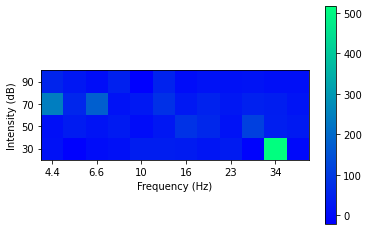

<Figure size 1200x800 with 0 Axes>

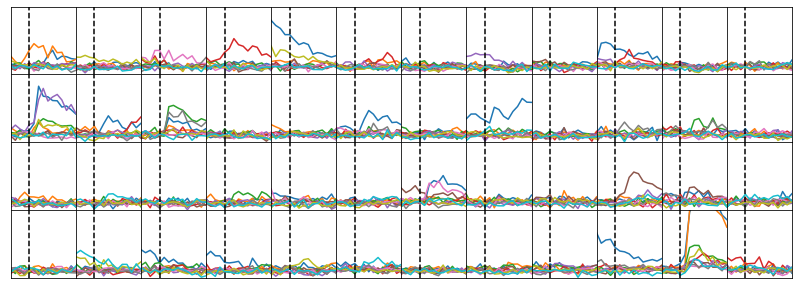

array([[191.98324585, 191.41473694, 439.11210327, 257.52120361],
       [215.5623291 , 198.89745483, 235.34915771, 203.65791321],
       [233.53314819, 188.92595215, 357.68362122, 228.48338623],
       [204.90264282, 198.45655518, 183.92458954, 248.85855408],
       [222.22134094, 203.66454773, 208.68651733, 285.06938477],
       [252.55766296, 198.69743958, 276.24545288, 217.02088623],
       [204.06806641, 298.85848694, 197.08549194, 187.08778076],
       [209.43091125, 233.85751038, 258.61100159, 197.8460968 ],
       [227.69228516, 208.72986145, 175.79360046, 209.66769409],
       [246.62390747, 281.51455383, 225.21804504, 267.84025879],
       [698.96455688, 253.64934692, 252.03664856, 185.66616821],
       [218.21297913, 217.36915283, 197.77282562, 195.39463501]])

In [47]:
cell_ID = 128
print(cell_dictionary[cell_ID]['active'])
plot_single_tuning_curve(cell_dictionary,cell_ID)
get_cell_tuning_by_peak(cell_dictionary[cell_ID]['traces'],True)
